In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
from matplotlib import pyplot as plt
import os
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Concatenate, Flatten, MaxPooling1D
from keras.models import Model
import pandas as pd
from itertools import islice


Using TensorFlow backend.


In [2]:
datapath = "E:\\Development Project\\Data\\GNPS Python Master\\Final Data.txt"
datapath_with_fragments = "E:\\Development Project\\Data\\GNPS Python Master\\Final Data With Fragments.txt"
fingerprints_path = "E:\\Development Project\\Data\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "E:\\Development Project\\Data\\GNPS Python Master\\Fingerprint Legend.txt"
num_samples = 5770
num_val_samples = 1000
numFeatures = 2995
val_fraction = 0.1
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1

In [3]:
def load_master_file(path, fragments = 0):
    MAX_MASS = 1000
    BIN_SIZE = 1
    NUM_FRAGMENTS = fragments
    
    mol_all = np.loadtxt(path, dtype="U25") # Get master file in as numpy array
    
    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows.
    
    # Construct empty Pandas dataframe of correct size.
    intensities = pd.DataFrame(0.0, index = mol_ids, columns=range((MAX_MASS//BIN_SIZE)+NUM_FRAGMENTS), dtype=float)
    print(intensities.index)
    
    # Populate the dataframe.
    for row in mol_all:
        intensities.at[row[0], float(row[1])-1] = float(row[2])
    
    # Convert populated dataframe into a numpy array for use by autoencoder
    np_matrix = intensities.values
    return np_matrix


def load_fingerprints_master():
    BITS = 320  # Total number of bits in fingerprint

    fp_all = np.loadtxt(fingerprints_path, dtype="U25")
    fp_ids = np.unique(fp_all[:, 0])

    print(fp_all.shape)
    print(fp_all.dtype)

    fingerprints = pd.DataFrame(0, index = fp_ids, columns=range(BITS), dtype=int)

    print(fingerprints.index)

    print(list(fingerprints))

    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    print(fingerprints)

    np_matrix = fingerprints.values
    return np_matrix


def load_fingerprint_legend():
    fingerprint_legend = []
    with open(fingerprints_names_path, 'r') as f:
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line)
    return fingerprint_legend

In [4]:
from keras.optimizers import SGD
def basic_autoencoder(x_train, epochs=100, encoded_dim=10):
    inputLayer = Input(shape=(x_train.shape[1],))  # fixed
    output_dims = x_train.shape[1]

    l = inputLayer
    l = Dense(256, activation='relu')(l)
    l = Dense(128, activation='relu')(l)
    l = Dense(16, activation='relu')(l)
    # l = Dense(encoded_dim, activation='relu')(l)

    latent_space = l

    #l2 = Dense(16, activation='relu')(l)
    l2 = Dense(128, activation='relu')(l)
    l2 = Dense(256, activation='relu')(l2)
    l2 = Dense(output_dims, activation='relu')(l2)

    out_layer = l2

    auto_model = Model(input=inputLayer, output=out_layer)  # Create model.
    

    sgd = SGD(lr=0.1)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)

    autoencoder_train = auto_model.fit(x_train, x_train, shuffle=False, validation_split = val_fraction, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    return auto_model  # Return the model, now trained.

def fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs=100, lr=0.5):
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    print(input_layer.shape)
    output_dims = x_train_fingerprints.shape[1]
    
    l = input_layer
    l = Dense(256, activation='relu')(l)
    l = Dense(128, activation='relu')(l)
    l = Dense(16, activation='relu')(l)
    
    latent_space = l
    
    l2 = Dense(128, activation='relu')(l)
    l2 = Dense(256, activation='linear')(l2)
    l2 = Dense(output_dims, activation='sigmoid')(l2)
    
    out_layer = l2
    
    auto_model = Model(input=input_layer, output=out_layer)
    
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_fingerprints, shuffle=False, validation_split = val_fraction, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    return auto_model


def simplified_fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs=100, lr=0.5):
    input_layer = Input(shape=(x_train_spectra.shape[1],))
    output_dims = x_train_fingerprints.shape[1]
    
    l = input_layer
    l = Dense(500, activation='relu')(l)
    l = Dense(200, activation='linear')(l)
    
    latent_space = l
    
    l2 = Dense(output_dims, activation='sigmoid')(l)
    
    out_layer = l2
    
    auto_model = Model(input=input_layer, output=out_layer)
    
    sgd = SGD(lr=lr)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    autoencoder_train = auto_model.fit(x_train_spectra, x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    return auto_model


layer = None


def conv_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, epochs=100, kernel_size=20):
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    dense_input = Input(shape=(x_train_dense.shape[1],))
    output_dims = x_train_fingerprints.shape[1]
    
    # 1D convolution on spectra
    c = conv_input
    print(kernel_size)
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    f = Flatten()(c) # Flatten for merging
    
    # Dense layer on spectra
    d = dense_input
    d = Dense(500, activation='relu')(d)
    
    # Merge convolution and dense layers
    m = concatenate(([f, d]))
    m = Dense(200, activation='linear')(m)
    
    latent_space = m
    
    l2 = Dense(output_dims, activation='sigmoid')(m)
    
    out_layer = l2
    
    auto_model = Model(inputs=[conv_input, dense_input], output=out_layer)
    
    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    autoencoder_train = auto_model.fit([x_train_conv, x_train_dense], x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    print(auto_model.get_layer("conv_layer"))
    
    global layer 
    
    layer = auto_model.get_layer("conv_layer")
    print(layer)
    print(len(layer.get_weights()[0]))
    print(layer.get_weights()[0][0].shape)
    
    return auto_model


def conv_only_autoencoder(x_train_conv, x_train_fingerprints, epochs=100, kernel_size=20):
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    output_dims = x_train_fingerprints.shape[1]

    # 1D convolution on spectra
    c = conv_input
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    c = MaxPooling1D()(c)
    c = Conv1D(16, kernel_size, activation='relu', padding='valid')(c)
    c = MaxPooling1D()(c)
    c = Flatten()(c)

    d = Dense(200, activation='linear')(c)

    l2 = Dense(output_dims, activation='sigmoid')(d)

    out_layer = l2

    auto_model = Model(inputs=conv_input, output=out_layer)

    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)

    autoencoder_train = auto_model.fit(x_train_conv, x_train_fingerprints, shuffle=False,
                                       validation_split=0.1, epochs=epochs)

    plot_loss(autoencoder_train, epochs)

    print(auto_model.get_layer("conv_layer"))

    global layer

    layer = auto_model.get_layer("conv_layer")
    print(layer)
    print(len(layer.get_weights()[0]))
    print(layer.get_weights()[0][0].shape)

    return auto_model

def conv_pool_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, epochs=100, kernel_size=20):
    conv_input = Input(shape=(x_train_conv.shape[1], 1))
    dense_input = Input(shape=(x_train_dense.shape[1],))
    output_dims = x_train_fingerprints.shape[1]
    
    # 1D convolution on spectra
    c = conv_input
    print(kernel_size)
    c = Conv1D(32, kernel_size, activation='relu', padding='valid', name='conv_layer')(conv_input)
    c = MaxPooling1D()(c)
    f = Flatten()(c) # Flatten for merging
    
    # Dense layer on spectra
    d = dense_input
    d = Dense(500, activation='relu')(d)
    
    # Merge convolution and dense layers
    m = concatenate(([f, d]))
    m = Dense(200, activation='linear')(m)
    
    latent_space = m
    
    l2 = Dense(output_dims, activation='sigmoid')(m)
    
    out_layer = l2
    
    auto_model = Model(inputs=[conv_input, dense_input], output=out_layer)
    
    sgd = SGD(lr=0.5)
    auto_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    autoencoder_train = auto_model.fit([x_train_conv, x_train_dense], x_train_fingerprints, shuffle=False, validation_split = 0.1, epochs=epochs)
    
    plot_loss(autoencoder_train, epochs)
    
    print(auto_model.get_layer("conv_layer"))
    
    global layer 
    
    layer = auto_model.get_layer("conv_layer")
    print(layer)
    print(len(layer.get_weights()[0]))
    print(layer.get_weights()[0][0].shape)
    
    return auto_model

In [5]:
def plot_loss(fitted_model, epochs):
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    epochs_label = epochs
    epochs = range(epochs)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss,'r', label='Validation loss')
    plt.title('Training and Validation Loss for ' + str(epochs_label) + ' epochs')
    plt.legend()
    plt.show()


def plot_input_output(auto_model, data, sample=0):
    decoded_data = auto_model.predict(data)
    print(data.shape)
    print(decoded_data.shape)

    for i, d in enumerate(data[sample]):
        if d>0.1:
            plt.plot([i,i],[0, d], color='g')
        if decoded_data[sample][i]>0.1:
            plt.plot([i,i],[0,-decoded_data[sample][i]], color='r')
    plt.show()
    
def plot_fingerprint_output(actual, predicted, sample=0):
    for i, d in enumerate(actual[sample]):
        plt.plot([i,i],[0,d], color='g')
        plt.plot([i,i],[0, -predicted[sample][i]], color = 'r')
        # if d>0:
           # print(fingerprint_names[i] + " Prediction: " + str(predicted[sample][i]))
    plt.show()


from sympy.utilities.iterables import multiset_permutations
def compute_auc(true, pred, permutations=500):
    val_start_index = int(num_samples-(num_samples*val_fraction)-1) # Index where validation samples begin.
    num_permutations = permutations  # Number of permutations to compute AUC scores for. 
    
    # Create structured array to hold statistics for each fingerprint.
    dtype = [('fp_id', int),('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((320,), dtype=dtype)
    
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((320, num_permutations))
    
    for fp_id in range(true.shape[1]-1): # For every substructure
        #if fp_id < 307:  # TODO: Fix fingerprints vector to remove non-fingerprint features.
            #print(fingerprint_names[fp_id])  # Name of substructure.
            
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id])
        if nonzero_vals > 0 and nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score.
            fp_true = true[val_start_index:, fp_id]
            # print(fp_true.shape)
            fp_pred = pred[val_start_index:, fp_id]
            # print(fp_pred.shape)
            score = metrics.roc_auc_score(fp_true, fp_pred)           
            # print(score)
                        
            # Compute AUC scores for permutations and compare to actual.
            counter = 0         
            # for p in multiset_permutations(fp_true, size=60):
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                if perm_score >= score:
                    counter = counter + 1
            percentage = (counter/num_permutations)*100
           
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)
            
    print("Done")
    return mol_stats, perm_scores


plt.rcParams['figure.dpi'] = default_dpi*2.2
def boxplots(real_stats, perm_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(fingerprint_names)[index]  # Grab name of each susbtructure to be plotted.
    #names = np.core.defchararray.add(names, real_stats[index]['nonzeros'].astype("U3"))

    print(len(index))
    print(names.size)
    print(real_stats.shape)
    
    plt.rcParams.update({'font.size': 6})

    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures

    plt.show()


def tandem_boxplots(real_stats, perm_stats, exp_stats, sample_fps):
    index = sample_fps['fp_id']  # Grab id of each substructure to be plotted, used as index in parallel arrays
    names = np.array(fingerprint_names)[index]  # Grab name of each susbtructure to be plotted.
    #names = np.core.defchararray.add(names, sample_fps['nonzeros'].astype("U3"))

    print(len(index))
    print(names.size)
    print(real_stats.shape)
    
    plt.rcParams.update({'font.size': 6})

    plt.figure()
    plt.boxplot(perm_stats[index].T, vert=False, labels = names) # Boxplot permutation AUC scores
    plt.scatter(real_stats[index]['auc'], range(1, len(index)+1)) # Scatter plot actual AUC scores for substructures
    plt.scatter(exp_stats[index]['auc'], range(1, len(index)+1), color = 'r')

    plt.show()

def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])
    
    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])
    
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index+bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')
    
    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substructures')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()
    
    plt.show()
    
    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps)
    
     # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]
    
    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])
    
    boxplots(base_stats, base_perm_scores, sample_fps)
    boxplots(exp_stats, exp_perm_scores, sample_fps)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps)
    
def hinton(matrix, max_weight=None, ax=None):
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [9]:
def train_diff_splits(path, name, splits=10):
    index_path = "E:\\Development Project\\Data\\Validation Spit Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 100
    path = path + name + " "
    experiment_stats = []
    for i in range(splits):
        print(i)
        curr_path = path + str(i) + ".txt"
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        
        enc_basic = fingerprint_autoencoder(x_train_dense, x_train_fingerprints, epochs=100)
        
        actual = x_train_fingerprints
        predicted = enc_basic.predict(x_train_dense)
        base_stats, base_perm_scores = compute_auc(actual, predicted)
        
        np.savetxt(curr_path, base_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(base_stats)
    return experiment_stats

def train_diff_splits_conv(path, name, kernel_size=20, splits=10):
    index_path = "E:\\Development Project\\Data\\Validation Spit Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 75
    path = path + name + " "
    experiment_stats = []
    for i in range(splits):
        print(i)
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        # Add dimension for Conv1D layer
        x_train_conv = np.expand_dims(x_train_dense, axis=2)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        
        enc_conv_only = conv_only_autoencoder(x_train_conv, x_train_fingerprints, kernel_size=kernel_size, epochs=epochs)
        actual = x_train_fingerprints
        predicted = enc_conv_only.predict(x_train_conv)
      
        exp_stats, exp_perm_scores = compute_auc(actual, predicted)
        curr_path = path + str(i) + ".txt"
        np.savetxt(curr_path, exp_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(exp_stats)
    return experiment_stats

def train_diff_splits_hybrid(path, name, kernel_size=20, splits=10):
    index_path = "E:\\Development Project\\Data\\Validation Spit Permutations.txt"
    permuted_indices = np.loadtxt(index_path, dtype=int, delimiter=',')
    epochs = 75
    path = path + name + " "
    experiment_stats = []
    for i in range(splits):
        print(i)
        x_train_dense = spectra[permuted_indices[:, i]]
        x_train_dense = np.log(x_train_dense+1)
        # Add dimension for Conv1D layer
        x_train_conv = np.expand_dims(x_train_dense, axis=2)
        x_train_fingerprints = fingerprints[permuted_indices[:, i]]
        
        enc_hybrid = conv_pool_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, kernel_size=kernel_size, epochs=epochs)
        actual = x_train_fingerprints
        predicted = enc_hybrid.predict([x_train_conv, x_train_dense])
        exp_stats, exp_perm_scores = compute_auc(actual, predicted)
        curr_path = path + str(i) + ".txt"
        np.savetxt(curr_path, exp_stats, fmt=['%d', '%d', '%f', '%f'])
        experiment_stats.append(exp_stats)
    return experiment_stats


In [10]:
spectra = load_master_file(path=datapath)
spectra_and_fragments = load_master_file(path=datapath_with_fragments, fragments=20)
fingerprints = load_fingerprints_master()
fingerprint_names = load_fingerprint_legend()

x_train_spectra = np.log(spectra+1) # Important, keep if restructuring code
x_train_fingerprints = fingerprints

Index(['CCMSLIB00000001548', 'CCMSLIB00000001549', 'CCMSLIB00000001550',
       'CCMSLIB00000001555', 'CCMSLIB00000001563', 'CCMSLIB00000001565',
       'CCMSLIB00000001566', 'CCMSLIB00000001568', 'CCMSLIB00000001569',
       'CCMSLIB00000001570',
       ...
       'CCMSLIB00000579916', 'CCMSLIB00000579917', 'CCMSLIB00000579918',
       'CCMSLIB00000579919', 'CCMSLIB00000579920', 'CCMSLIB00000579921',
       'CCMSLIB00000579922', 'CCMSLIB00000579923', 'CCMSLIB00000579924',
       'CCMSLIB00000579925'],
      dtype='object', length=5770)
Index(['CCMSLIB00000001548', 'CCMSLIB00000001549', 'CCMSLIB00000001550',
       'CCMSLIB00000001555', 'CCMSLIB00000001563', 'CCMSLIB00000001565',
       'CCMSLIB00000001566', 'CCMSLIB00000001568', 'CCMSLIB00000001569',
       'CCMSLIB00000001570',
       ...
       'CCMSLIB00000579916', 'CCMSLIB00000579917', 'CCMSLIB00000579918',
       'CCMSLIB00000579919', 'CCMSLIB00000579920', 'CCMSLIB00000579921',
       'CCMSLIB00000579922', 'CCMSLIB00000579923', '

0
20


c:\users\matej\envs\masters\lib\site-packages\ipykernel_launcher.py:203: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 5s 1ms/step - loss: 0.0453 - val_loss: 0.0259
Epoch 2/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0257 - val_loss: 0.0253
Epoch 3/75
5193/5193 [==============================] - 3s 586us/step - loss: 0.0251 - val_loss: 0.0249
Epoch 4/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0247 - val_loss: 0.0246
Epoch 5/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0244 - val_loss: 0.0243
Epoch 6/75
5193/5193 [==============================] - 3s 588us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 7/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0237 - val_loss: 0.0238
Epoch 8/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0234 - val_loss: 0.0235
Epoch 9/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0232 - val_loss: 0.0233
Epoch 10/75
5193/51

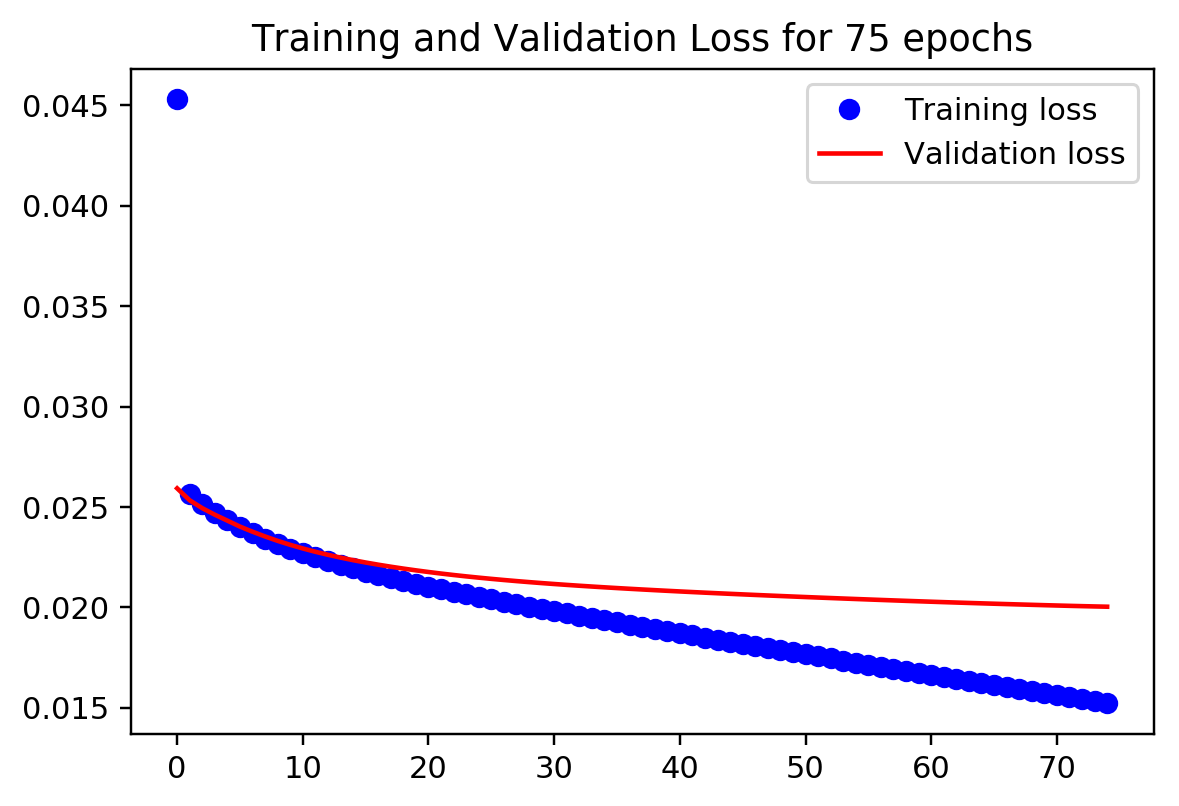

20
(1, 32)
Done
1
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 717us/step - loss: 0.0470 - val_loss: 0.0266
Epoch 2/75
5193/5193 [==============================] - 3s 588us/step - loss: 0.0256 - val_loss: 0.0259
Epoch 3/75
5193/5193 [==============================] - 3s 588us/step - loss: 0.0250 - val_loss: 0.0255
Epoch 4/75
5193/5193 [==============================] - 3s 591us/step - loss: 0.0246 - val_loss: 0.0251
Epoch 5/75
5193/5193 [==============================] - 3s 587us/step - loss: 0.0243 - val_loss: 0.0249
Epoch 6/75
5193/5193 [==============================] - 3s 588us/step - loss: 0.0240 - val_loss: 0.0246
Epoch 7/75
5193/5193 [==============================] - 3s 596us/step - loss: 0.0237 - val_loss: 0.0244
Epoch 8/75
5193/5193 [==============================] - 3s 594us/step - loss: 0.0234 - val_loss: 0.0242
Epoch 9/75
5193/5193 [==============================] - 3s 586us/step - loss: 0.0232 - val_loss: 0.0

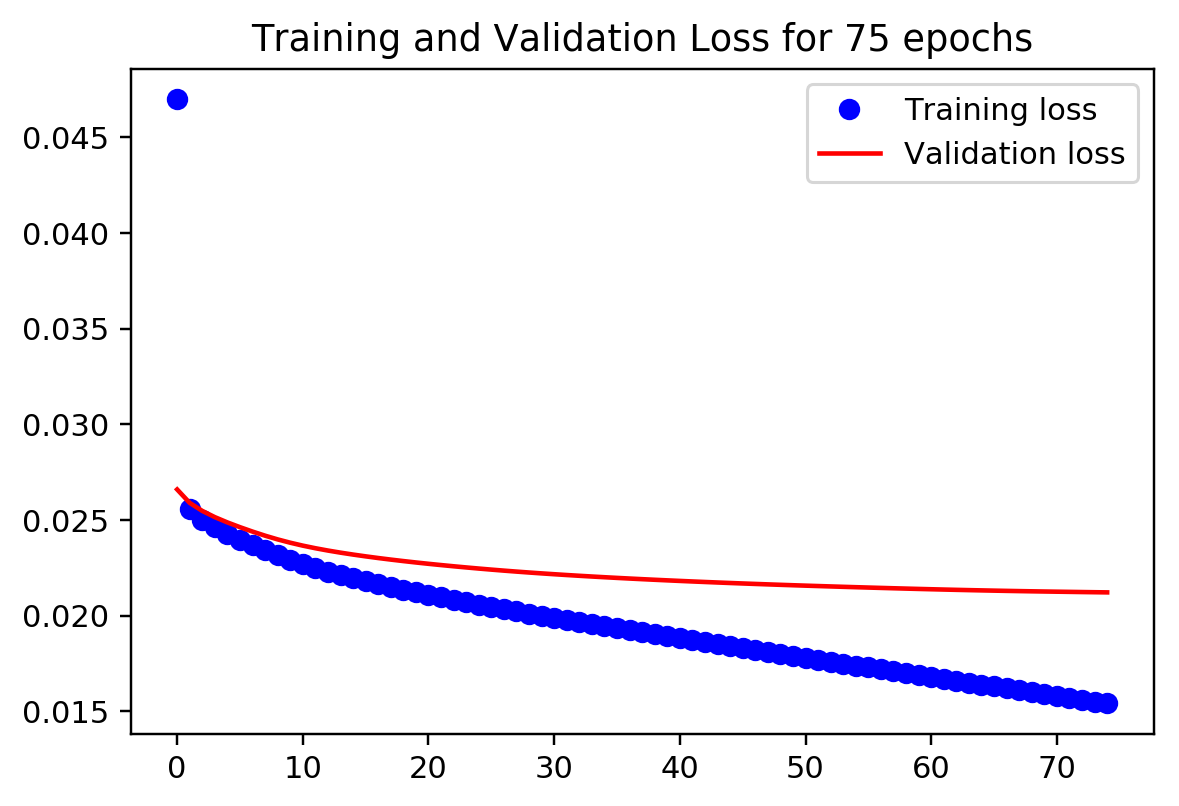

20
(1, 32)
Done
2
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 720us/step - loss: 0.0466 - val_loss: 0.0260
Epoch 2/75
5193/5193 [==============================] - 3s 579us/step - loss: 0.0258 - val_loss: 0.0255
Epoch 3/75
5193/5193 [==============================] - 3s 578us/step - loss: 0.0253 - val_loss: 0.0252
Epoch 4/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0248 - val_loss: 0.0249
Epoch 5/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0245 - val_loss: 0.0246
Epoch 6/75
5193/5193 [==============================] - 3s 577us/step - loss: 0.0241 - val_loss: 0.0243
Epoch 7/75
5193/5193 [==============================] - 3s 576us/step - loss: 0.0238 - val_loss: 0.0240
Epoch 8/75
5193/5193 [==============================] - 3s 577us/step - loss: 0.0235 - val_loss: 0.0238
Epoch 9/75
5193/5193 [==============================] - 3s 578us/step - loss: 0.0233 - val_loss: 0.0

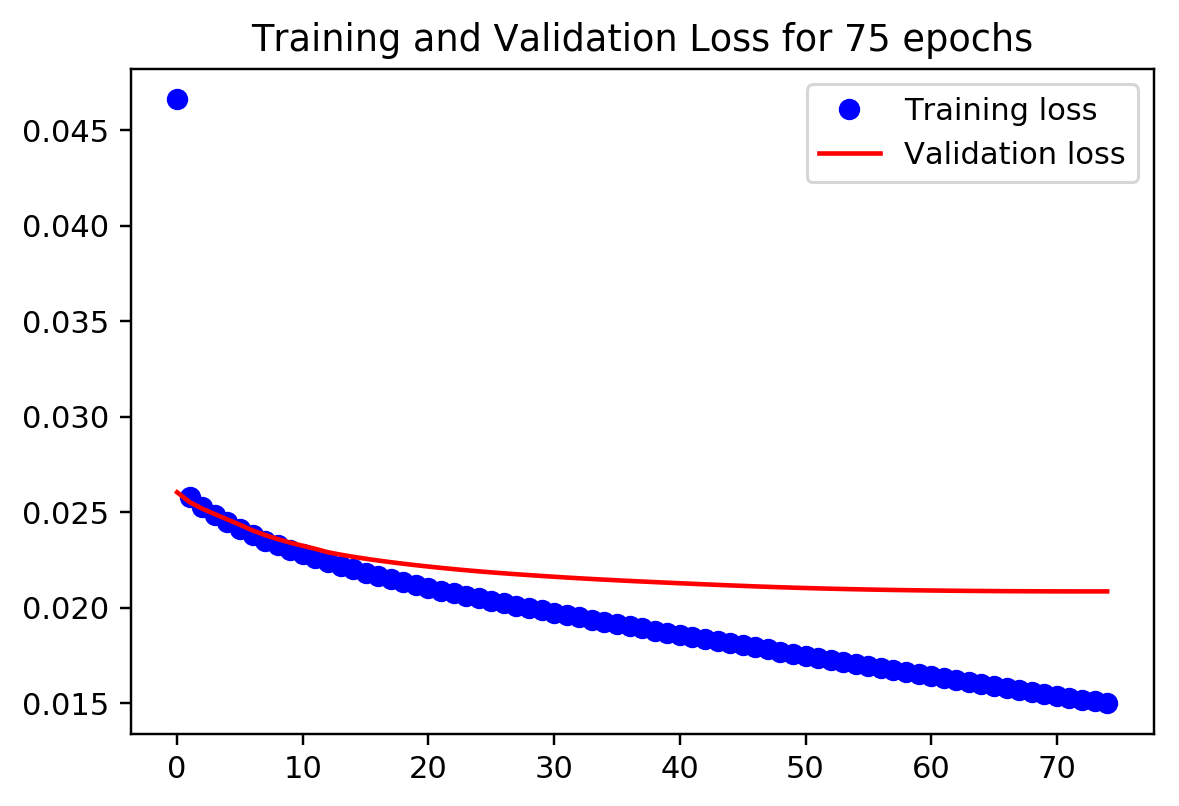

20
(1, 32)
Done
3
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 721us/step - loss: 0.0478 - val_loss: 0.0264
Epoch 2/75
5193/5193 [==============================] - 3s 579us/step - loss: 0.0257 - val_loss: 0.0259
Epoch 3/75
5193/5193 [==============================] - 3s 578us/step - loss: 0.0251 - val_loss: 0.0255
Epoch 4/75
5193/5193 [==============================] - 3s 579us/step - loss: 0.0246 - val_loss: 0.0252
Epoch 5/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0243 - val_loss: 0.0250
Epoch 6/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0239 - val_loss: 0.0247
Epoch 7/75
5193/5193 [==============================] - 3s 578us/step - loss: 0.0236 - val_loss: 0.0245
Epoch 8/75
5193/5193 [==============================] - 3s 581us/step - loss: 0.0234 - val_loss: 0.0243
Epoch 9/75
5193/5193 [==============================] - 3s 578us/step - loss: 0.0231 - val_loss: 0.0

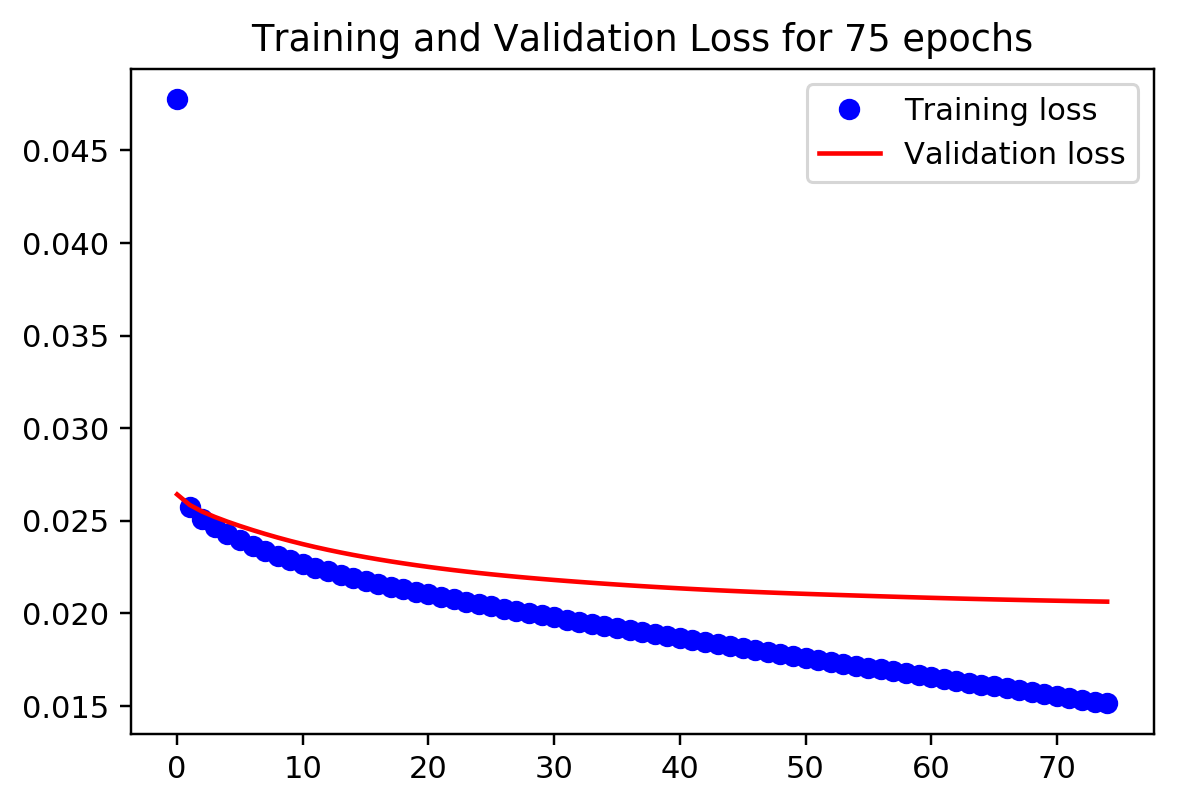

20
(1, 32)
Done
4
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 724us/step - loss: 0.0472 - val_loss: 0.0261
Epoch 2/75
5193/5193 [==============================] - 3s 587us/step - loss: 0.0256 - val_loss: 0.0254
Epoch 3/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 4/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0247 - val_loss: 0.0248
Epoch 5/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0243 - val_loss: 0.0245
Epoch 6/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0240 - val_loss: 0.0243
Epoch 7/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0237 - val_loss: 0.0241
Epoch 8/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0235 - val_loss: 0.0239
Epoch 9/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0232 - val_loss: 0.0

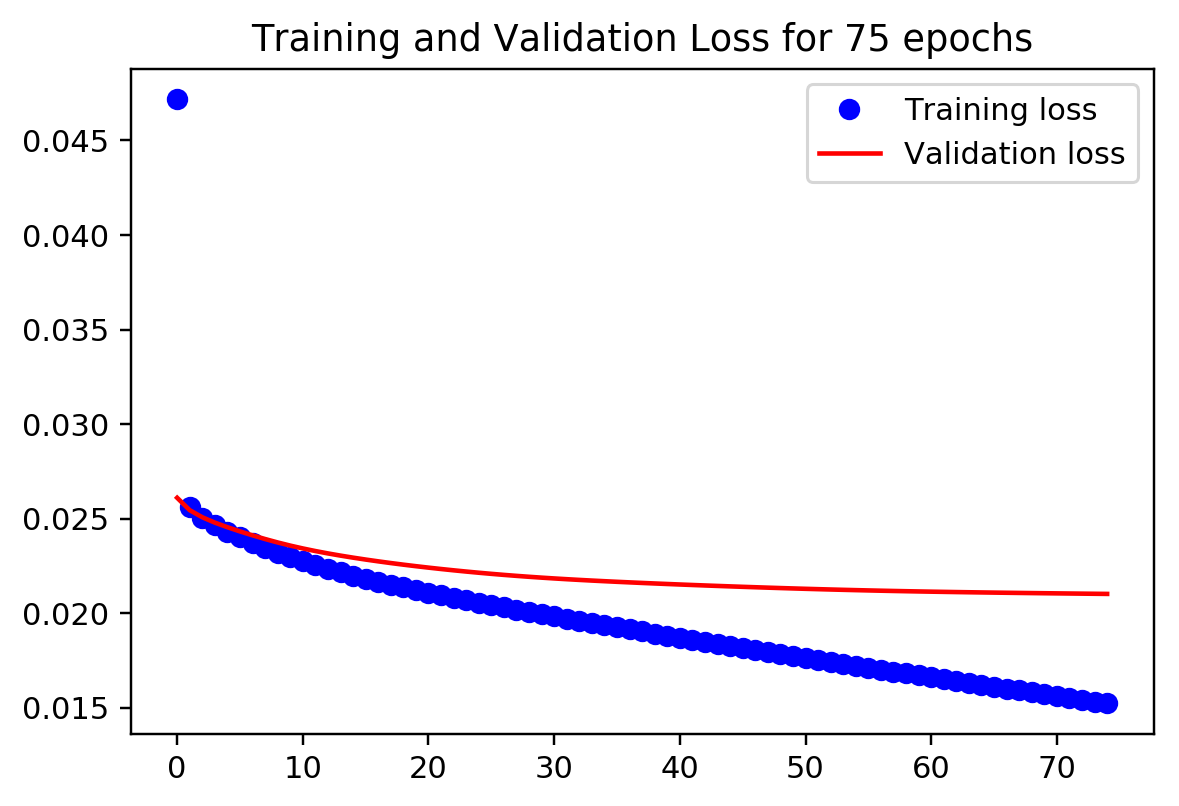

20
(1, 32)
Done
5
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 746us/step - loss: 0.0443 - val_loss: 0.0258
Epoch 2/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0258 - val_loss: 0.0252
Epoch 3/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0252 - val_loss: 0.0248
Epoch 4/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0248 - val_loss: 0.0245
Epoch 5/75
5193/5193 [==============================] - 3s 586us/step - loss: 0.0244 - val_loss: 0.0242
Epoch 6/75
5193/5193 [==============================] - 3s 586us/step - loss: 0.0241 - val_loss: 0.0240
Epoch 7/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0238 - val_loss: 0.0238
Epoch 8/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0235 - val_loss: 0.0236
Epoch 9/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0232 - val_loss: 0.0

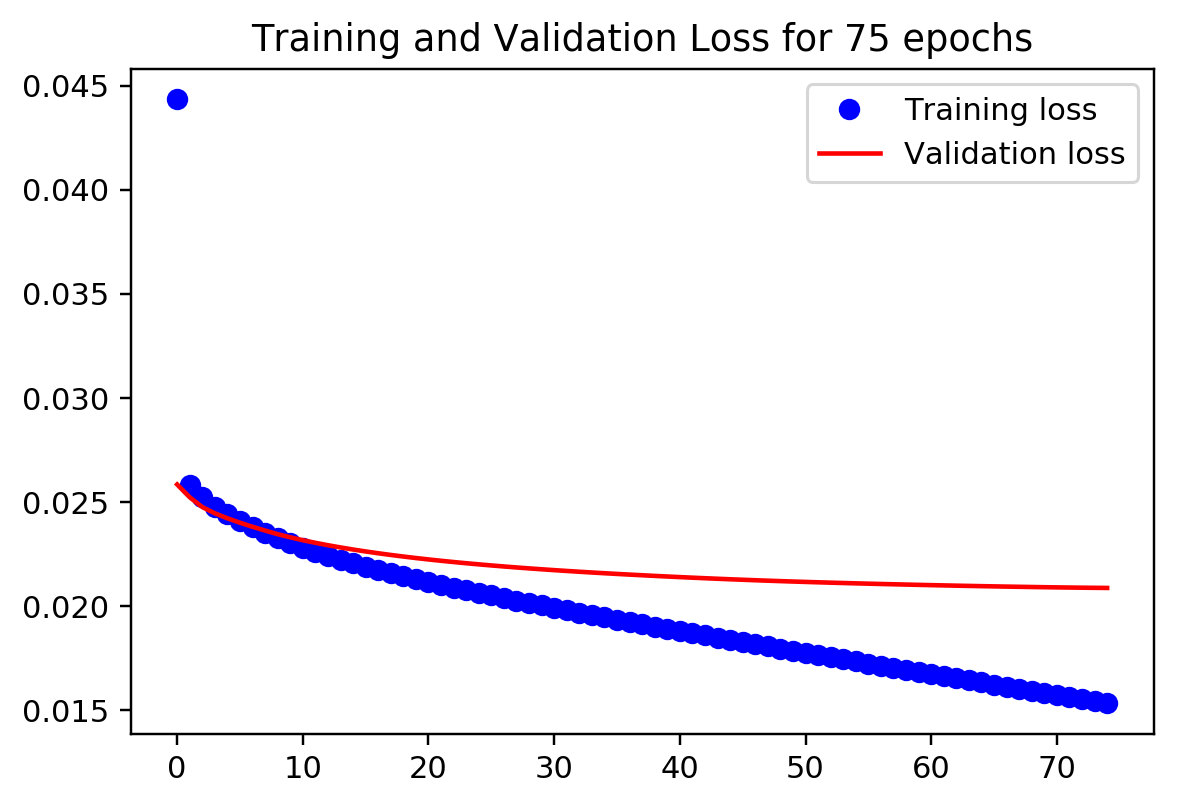

20
(1, 32)
Done
6
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 734us/step - loss: 0.0455 - val_loss: 0.0256
Epoch 2/75
5193/5193 [==============================] - 3s 581us/step - loss: 0.0257 - val_loss: 0.0249
Epoch 3/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0251 - val_loss: 0.0245
Epoch 4/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0247 - val_loss: 0.0241
Epoch 5/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0243 - val_loss: 0.0238
Epoch 6/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0240 - val_loss: 0.0235
Epoch 7/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0237 - val_loss: 0.0232
Epoch 8/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0234 - val_loss: 0.0230
Epoch 9/75
5193/5193 [==============================] - 3s 588us/step - loss: 0.0231 - val_loss: 0.0

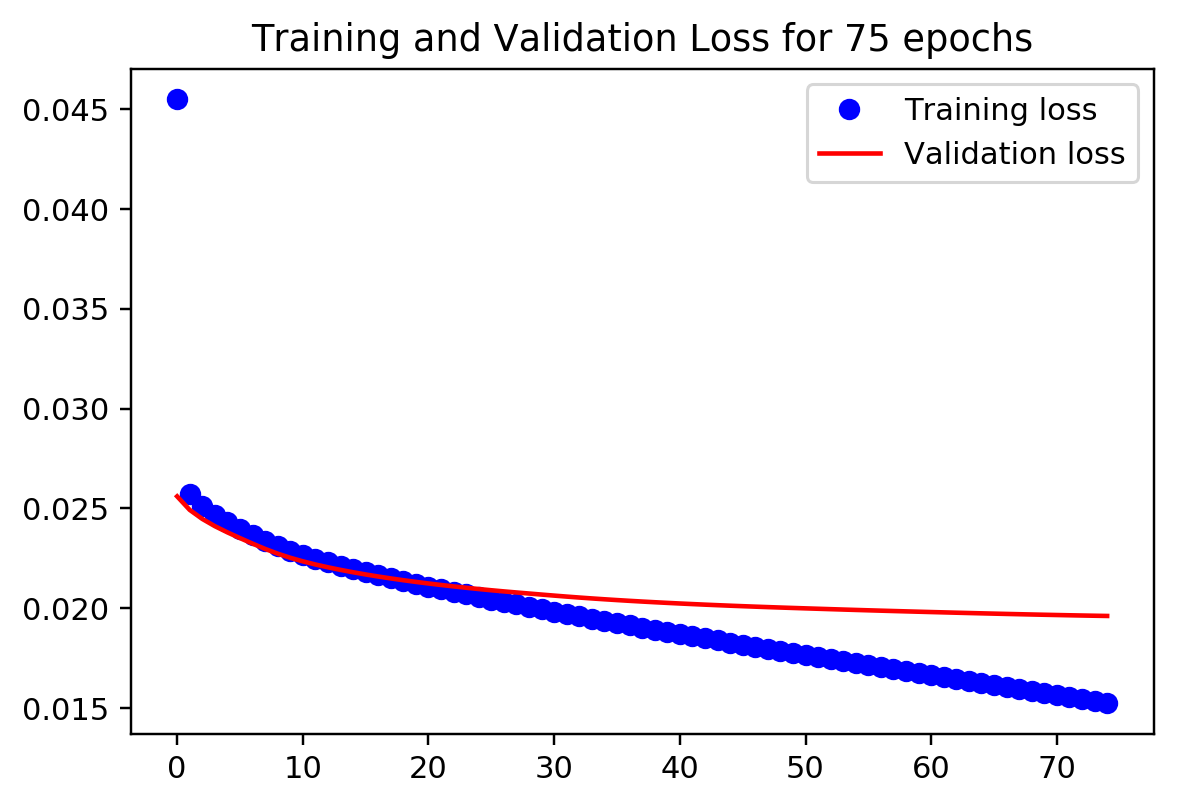

20
(1, 32)
Done
7
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 741us/step - loss: 0.0481 - val_loss: 0.0262
Epoch 2/75
5193/5193 [==============================] - 3s 581us/step - loss: 0.0256 - val_loss: 0.0255
Epoch 3/75
5193/5193 [==============================] - 3s 581us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 4/75
5193/5193 [==============================] - 3s 580us/step - loss: 0.0246 - val_loss: 0.0247
Epoch 5/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0243 - val_loss: 0.0243
Epoch 6/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0239 - val_loss: 0.0240
Epoch 7/75
5193/5193 [==============================] - 3s 581us/step - loss: 0.0236 - val_loss: 0.0238
Epoch 8/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0233 - val_loss: 0.0235
Epoch 9/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0231 - val_loss: 0.0

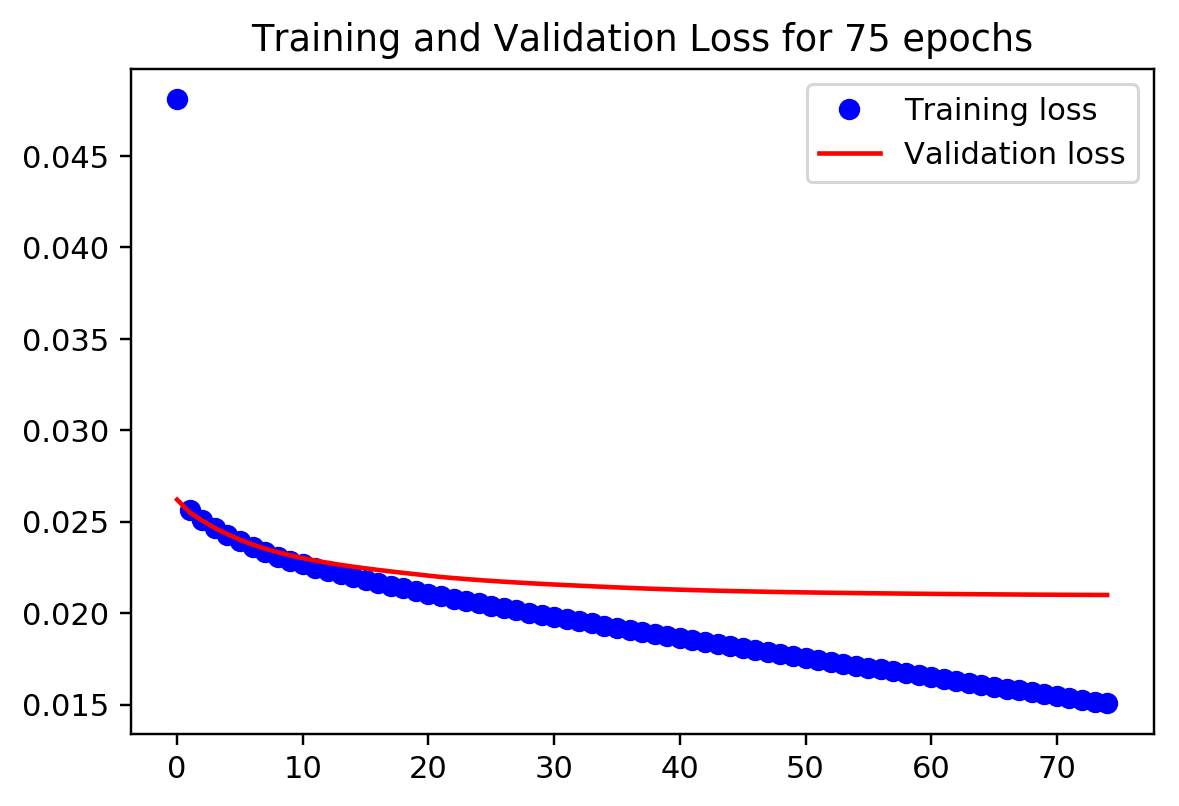

20
(1, 32)
Done
8
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 746us/step - loss: 0.0447 - val_loss: 0.0266
Epoch 2/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0255 - val_loss: 0.0260
Epoch 3/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0250 - val_loss: 0.0256
Epoch 4/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0245 - val_loss: 0.0253
Epoch 5/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0241 - val_loss: 0.0251
Epoch 6/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0238 - val_loss: 0.0248
Epoch 7/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0235 - val_loss: 0.0246
Epoch 8/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0232 - val_loss: 0.0244
Epoch 9/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0229 - val_loss: 0.0

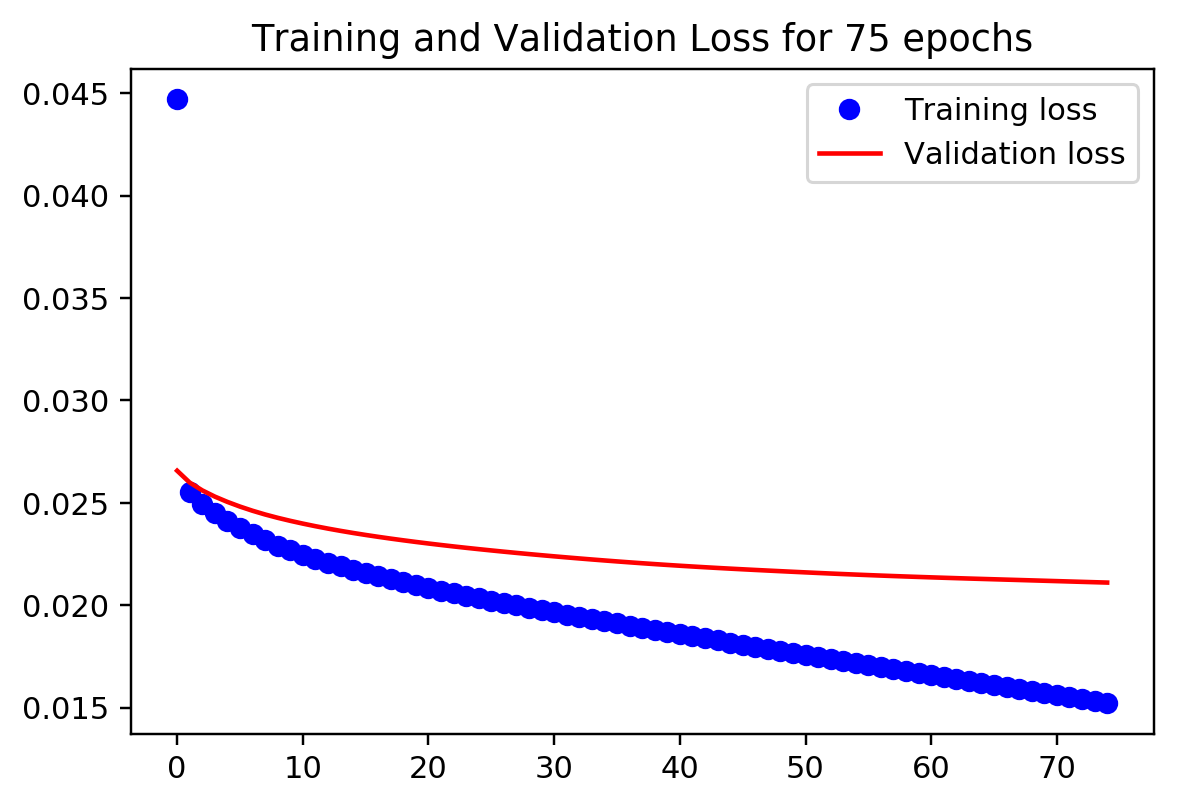

20
(1, 32)
Done
9
20
Train on 5193 samples, validate on 577 samples
Epoch 1/75
5193/5193 [==============================] - 4s 768us/step - loss: 0.0455 - val_loss: 0.0260
Epoch 2/75
5193/5193 [==============================] - 3s 584us/step - loss: 0.0257 - val_loss: 0.0254
Epoch 3/75
5193/5193 [==============================] - 3s 586us/step - loss: 0.0251 - val_loss: 0.0250
Epoch 4/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0247 - val_loss: 0.0247
Epoch 5/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0243 - val_loss: 0.0244
Epoch 6/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0240 - val_loss: 0.0241
Epoch 7/75
5193/5193 [==============================] - 3s 583us/step - loss: 0.0237 - val_loss: 0.0239
Epoch 8/75
5193/5193 [==============================] - 3s 582us/step - loss: 0.0234 - val_loss: 0.0237
Epoch 9/75
5193/5193 [==============================] - 3s 585us/step - loss: 0.0232 - val_loss: 0.0

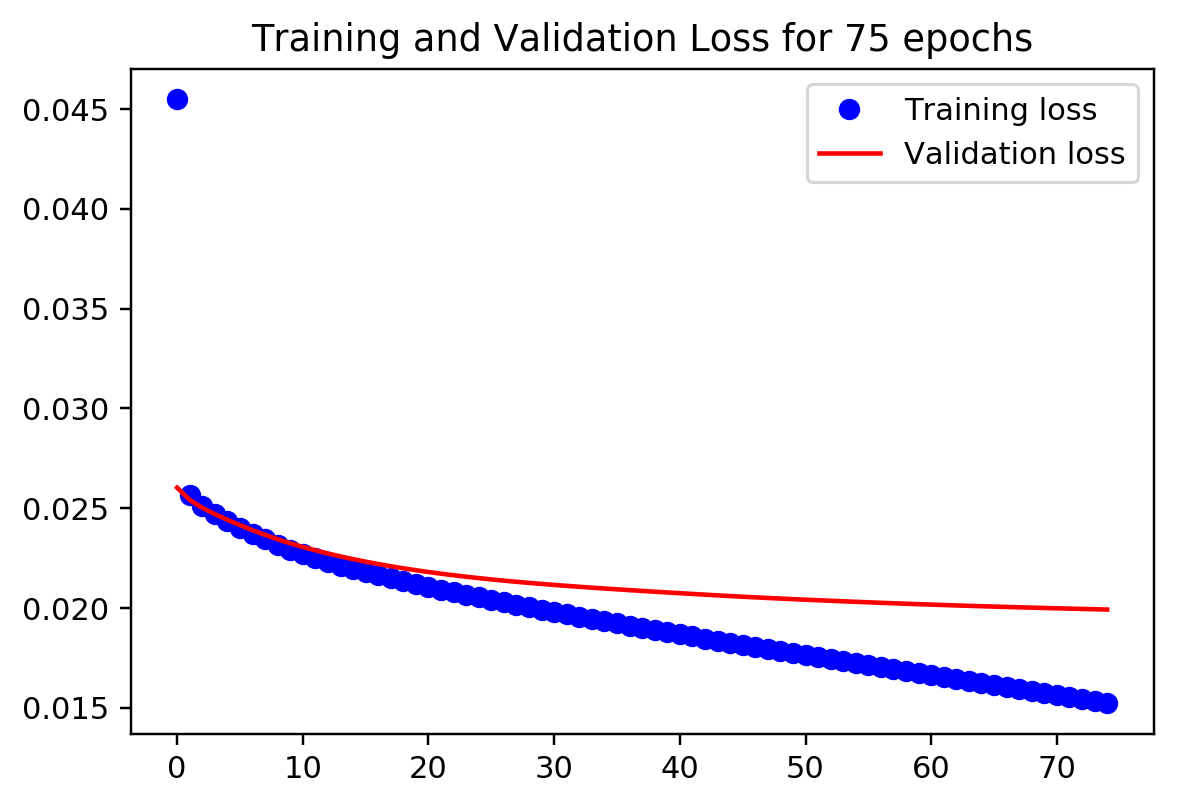

20
(1, 32)
Done


In [11]:
path = "E:\\Development Project\\Data\\Kernel Experiments\\"
name = "Hybrid Pooled"
exp_stats = train_diff_splits_hybrid(path=path, name=name, kernel_size=20)

(?, 1000)


c:\users\matej\envs\masters\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 5193 samples, validate on 577 samples
Epoch 1/100
5193/5193 [==============================] - 1s 216us/step - loss: 0.0668 - val_loss: 0.0281
Epoch 2/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0264 - val_loss: 0.0275
Epoch 3/100
5193/5193 [==============================] - 1s 115us/step - loss: 0.0262 - val_loss: 0.0271
Epoch 4/100
5193/5193 [==============================] - 1s 122us/step - loss: 0.0260 - val_loss: 0.0267
Epoch 5/100
5193/5193 [==============================] - 1s 124us/step - loss: 0.0260 - val_loss: 0.0266
Epoch 6/100
5193/5193 [==============================] - 1s 120us/step - loss: 0.0259 - val_loss: 0.0265
Epoch 7/100
5193/5193 [==============================] - 1s 127us/step - loss: 0.0258 - val_loss: 0.0264
Epoch 8/100
5193/5193 [==============================] - 1s 116us/step - loss: 0.0258 - val_loss: 0.0263
Epoch 9/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0257 - val_loss: 0.0262
Epoch 10

Epoch 78/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0184 - val_loss: 0.0220
Epoch 79/100
5193/5193 [==============================] - 1s 111us/step - loss: 0.0183 - val_loss: 0.0221
Epoch 80/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0182 - val_loss: 0.0221
Epoch 81/100
5193/5193 [==============================] - 1s 113us/step - loss: 0.0181 - val_loss: 0.0221
Epoch 82/100
5193/5193 [==============================] - 1s 112us/step - loss: 0.0180 - val_loss: 0.0222
Epoch 83/100
5193/5193 [==============================] - 1s 113us/step - loss: 0.0179 - val_loss: 0.0222
Epoch 84/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0178 - val_loss: 0.0223
Epoch 85/100
5193/5193 [==============================] - 1s 114us/step - loss: 0.0177 - val_loss: 0.0223
Epoch 86/100
5193/5193 [==============================] - 1s 112us/step - loss: 0.0175 - val_loss: 0.0223
Epoch 87/100
5193/5193 [======================

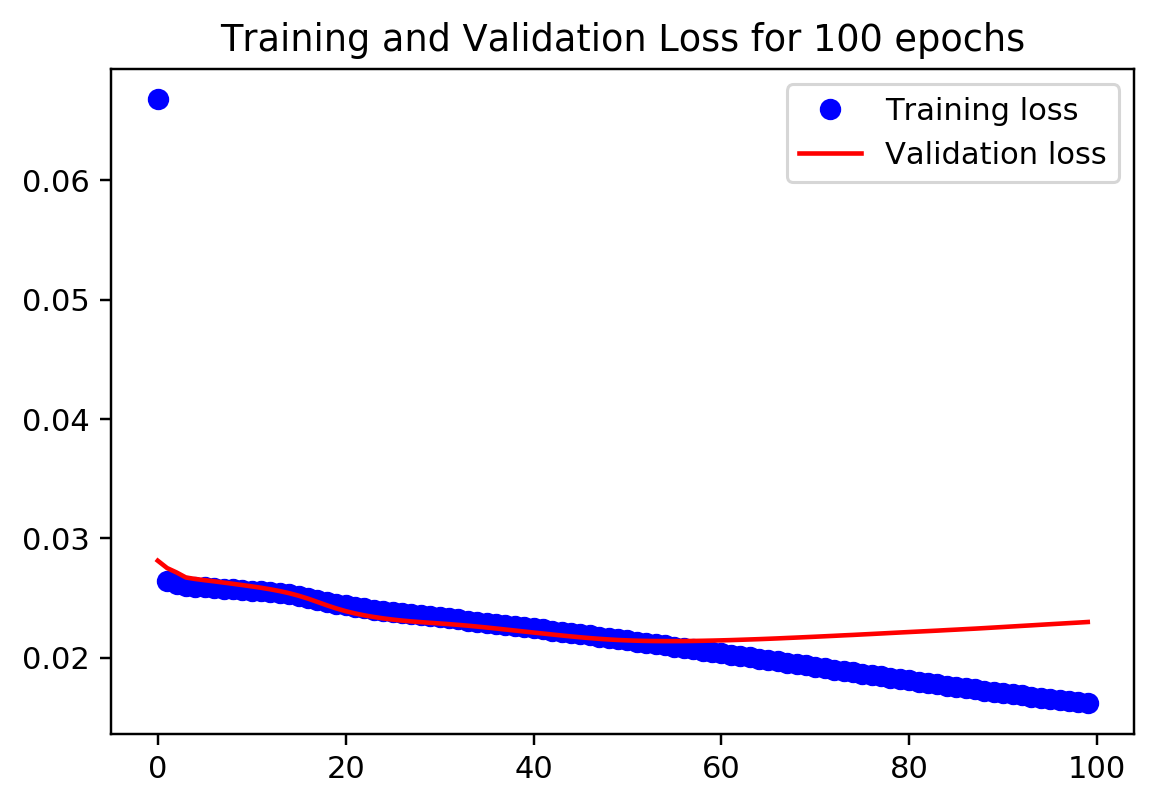

Done


In [22]:
x_train_spectra = np.log(spectra+1) # Important, keep if restructuring code
x_train_fingerprints = fingerprints
e1=100
enc= fingerprint_autoencoder(x_train_spectra, x_train_fingerprints, epochs = e1)

actual = x_train_fingerprints
predicted = enc.predict(x_train_spectra)

baseline_stats, baseline_perm_scores = compute_auc(actual, predicted)


20


c:\users\matej\envs\masters\lib\site-packages\ipykernel_launcher.py:203: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Train on 5193 samples, validate on 577 samples
Epoch 1/100
5193/5193 [==============================] - 4s 722us/step - loss: 0.0475 - val_loss: 0.0248
Epoch 2/100
5193/5193 [==============================] - 3s 584us/step - loss: 0.0254 - val_loss: 0.0245
Epoch 3/100
5193/5193 [==============================] - 3s 585us/step - loss: 0.0249 - val_loss: 0.0238
Epoch 4/100
5193/5193 [==============================] - 3s 583us/step - loss: 0.0245 - val_loss: 0.0233
Epoch 5/100
5193/5193 [==============================] - 3s 585us/step - loss: 0.0242 - val_loss: 0.0228
Epoch 6/100
5193/5193 [==============================] - 3s 583us/step - loss: 0.0239 - val_loss: 0.0225
Epoch 7/100
5193/5193 [==============================] - 3s 586us/step - loss: 0.0236 - val_loss: 0.0222
Epoch 8/100
5193/5193 [==============================] - 3s 595us/step - loss: 0.0234 - val_loss: 0.0219
Epoch 9/100
5193/5193 [==============================] - 3s 584us/step - loss: 0.0231 - val_loss: 0.0217
Epoch 10

Epoch 78/100
5193/5193 [==============================] - 3s 613us/step - loss: 0.0149 - val_loss: 0.0212
Epoch 79/100
5193/5193 [==============================] - 3s 585us/step - loss: 0.0148 - val_loss: 0.0212
Epoch 80/100
5193/5193 [==============================] - 3s 579us/step - loss: 0.0147 - val_loss: 0.0212
Epoch 81/100
5193/5193 [==============================] - 3s 581us/step - loss: 0.0146 - val_loss: 0.0213
Epoch 82/100
5193/5193 [==============================] - 3s 580us/step - loss: 0.0145 - val_loss: 0.0213
Epoch 83/100
5193/5193 [==============================] - 3s 580us/step - loss: 0.0144 - val_loss: 0.0213
Epoch 84/100
5193/5193 [==============================] - 3s 579us/step - loss: 0.0143 - val_loss: 0.0214
Epoch 85/100
5193/5193 [==============================] - 3s 580us/step - loss: 0.0142 - val_loss: 0.0214
Epoch 86/100
5193/5193 [==============================] - 3s 581us/step - loss: 0.0141 - val_loss: 0.0214
Epoch 87/100
5193/5193 [======================

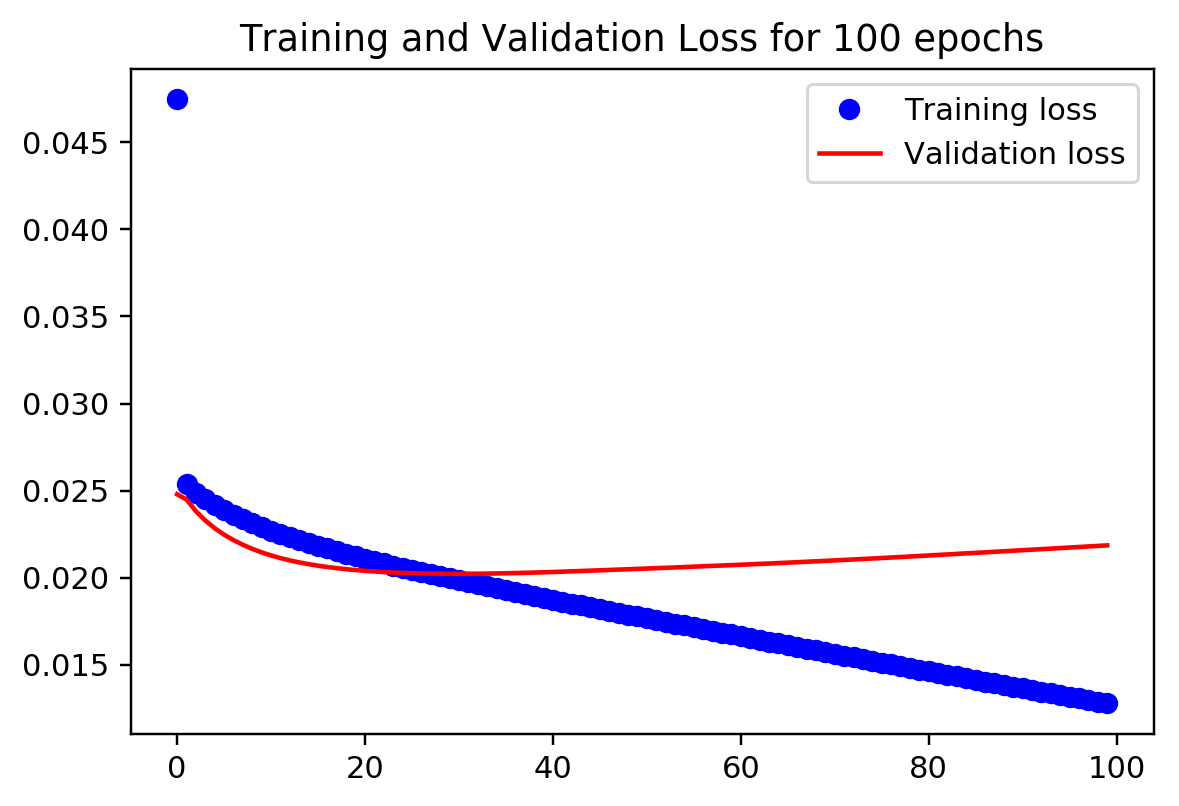

20
(1, 32)
Done


In [23]:
x_train_dense = spectra
x_train_dense = np.log(x_train_dense+1)
# Add dimension for Conv1D layer
x_train_conv = np.expand_dims(x_train_dense, axis=2)
x_train_fingerprints = fingerprints
        
enc_hybrid_pool = conv_pool_autoencoder(x_train_conv, x_train_dense, x_train_fingerprints, kernel_size=20, epochs=100)

actual = x_train_fingerprints
predicted = enc_hybrid_pool.predict([x_train_conv, x_train_dense])

exp_stats, exp_perm_scores = compute_auc(actual, predicted)



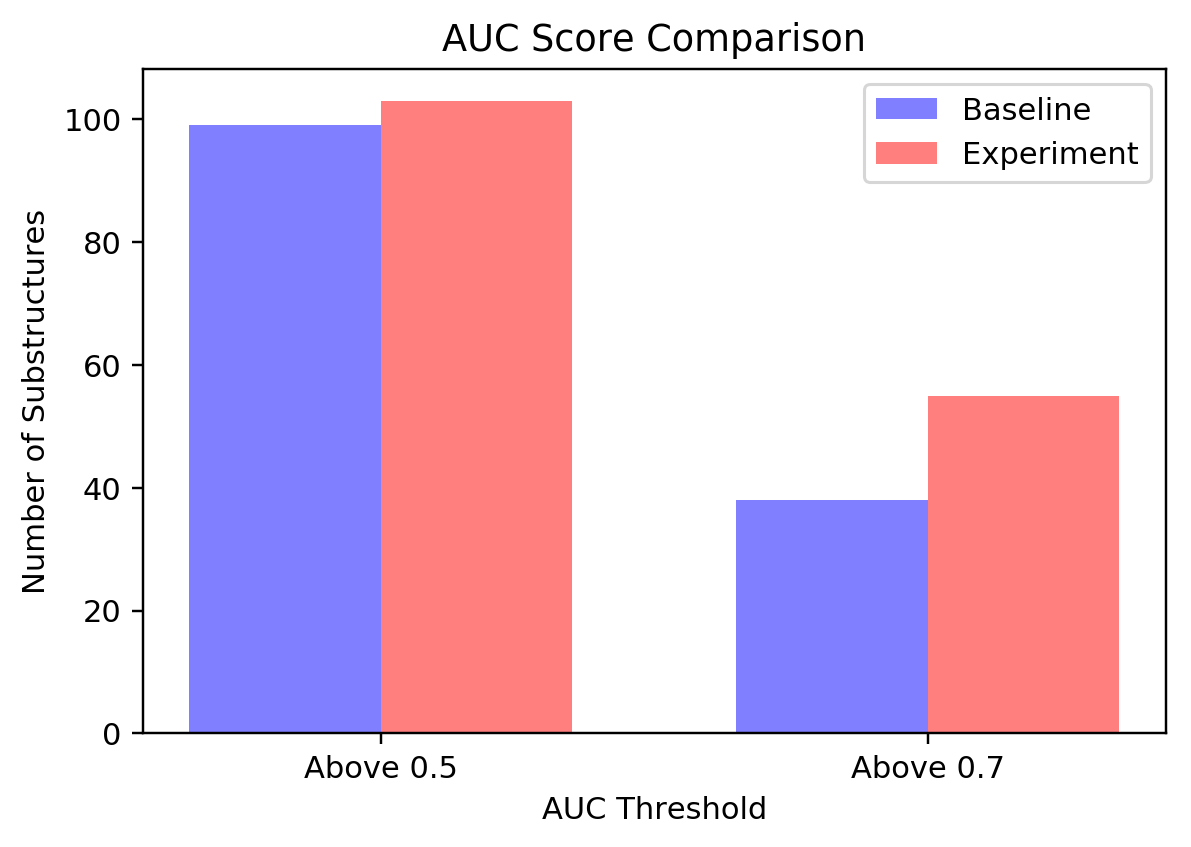

35
35
(320,)


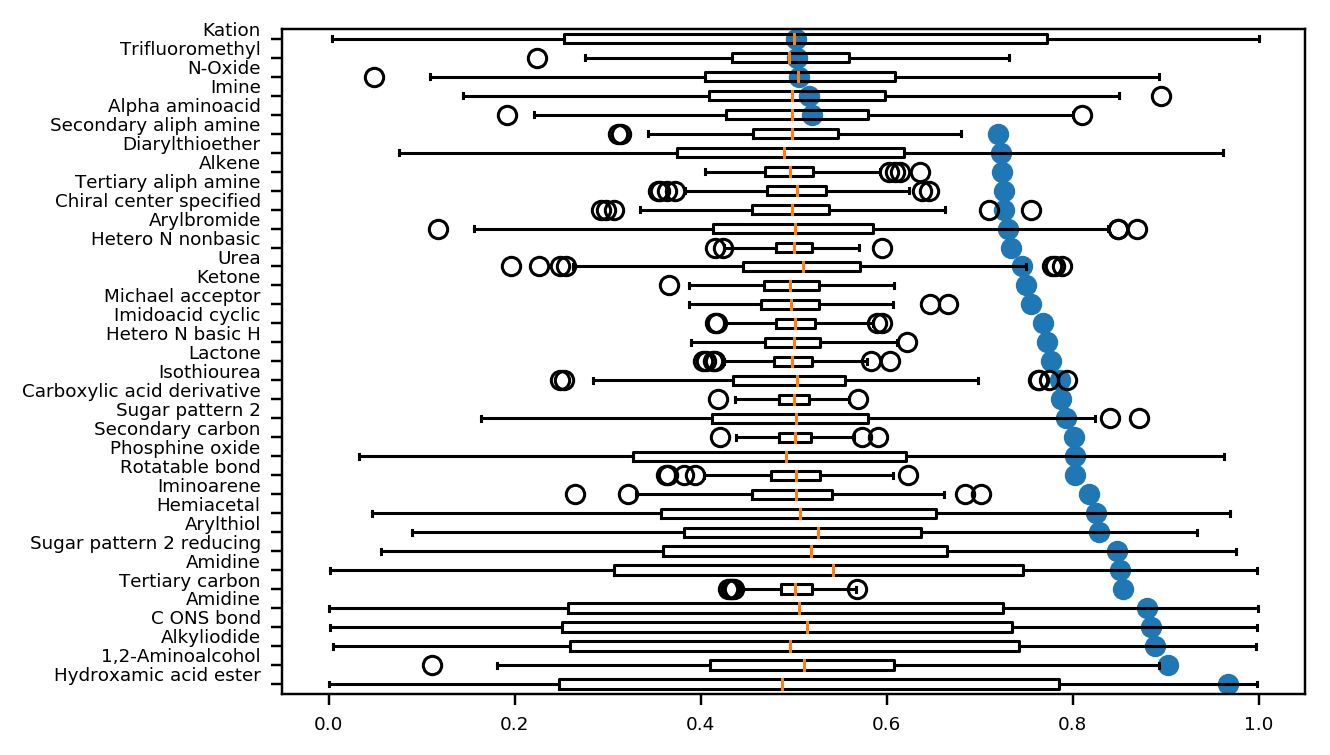

35
35
(320,)


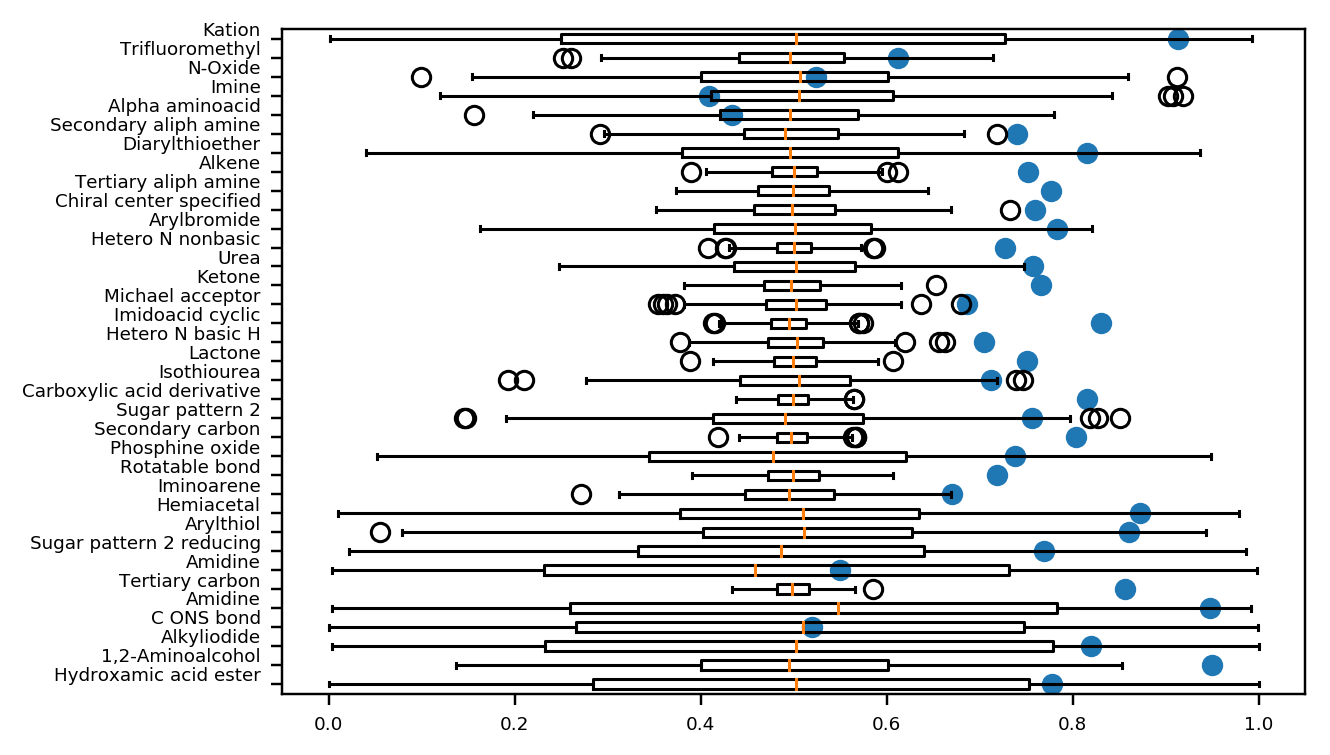

35
35
(320,)


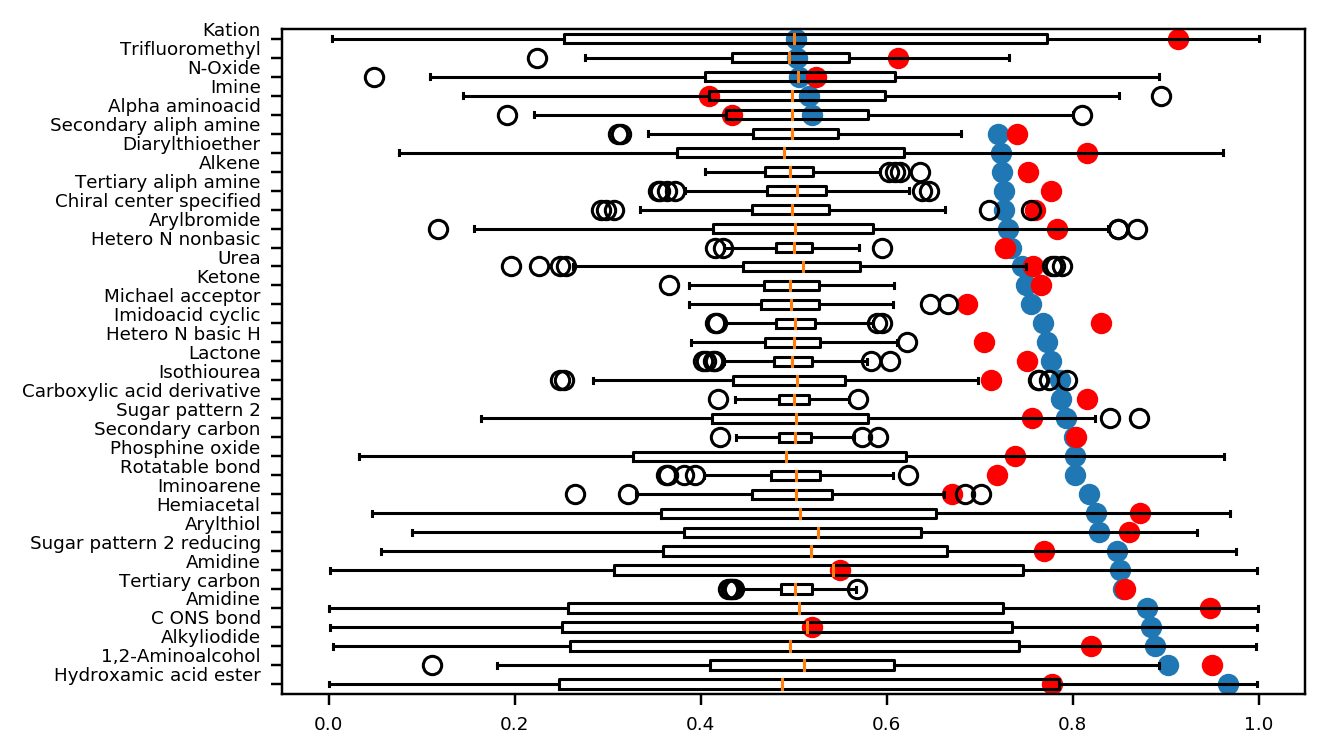

35
35
(320,)


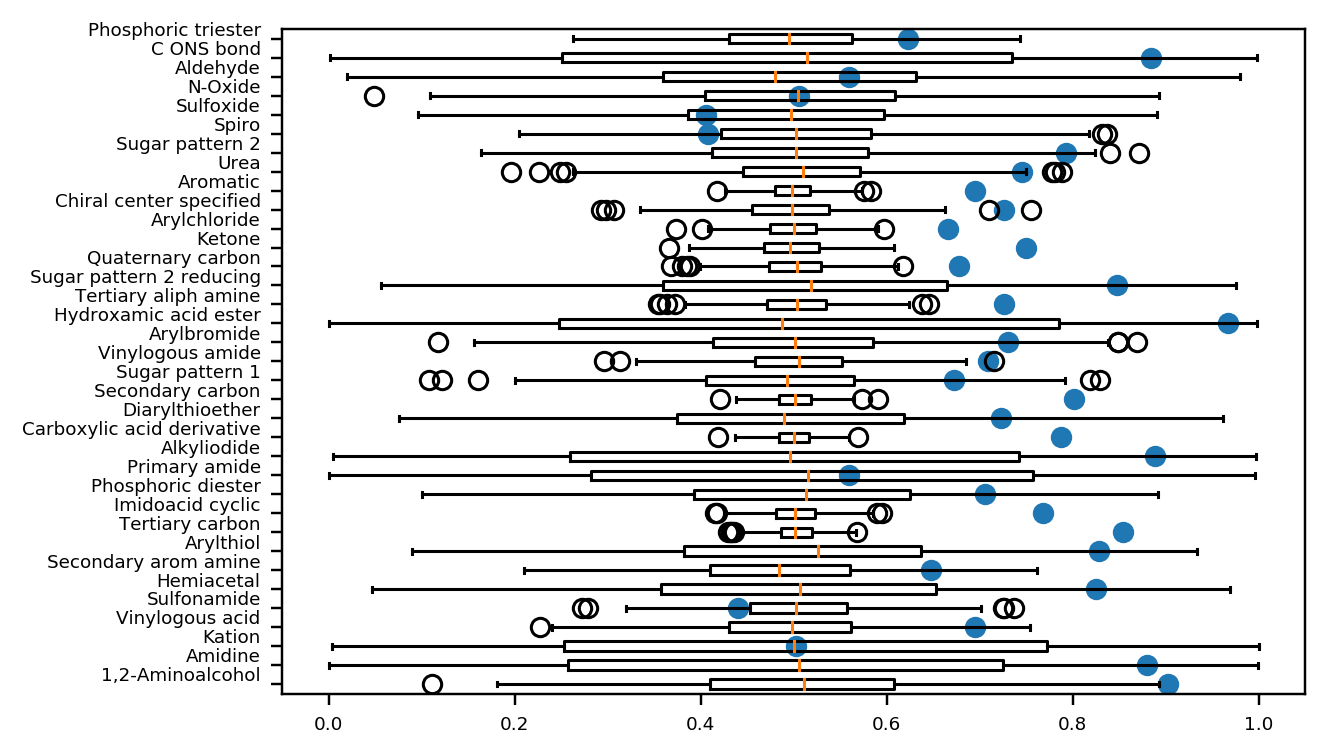

35
35
(320,)


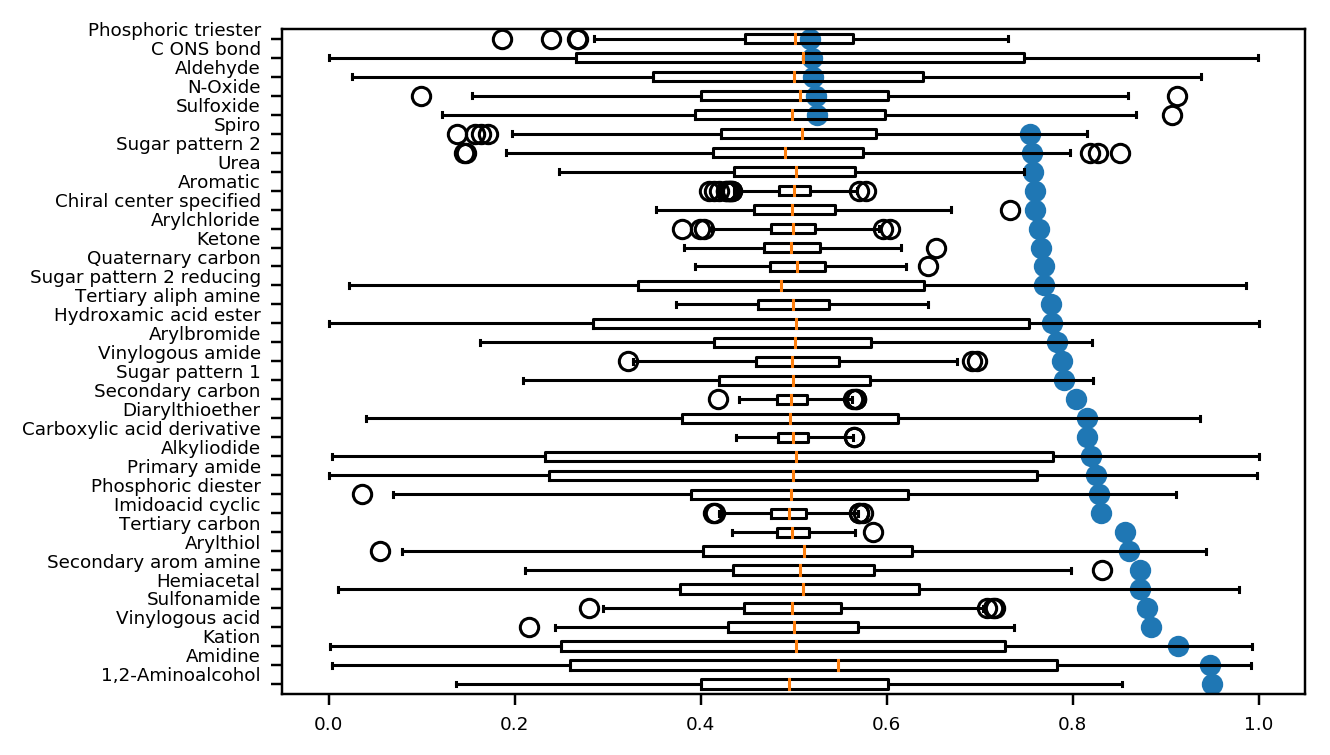

35
35
(320,)


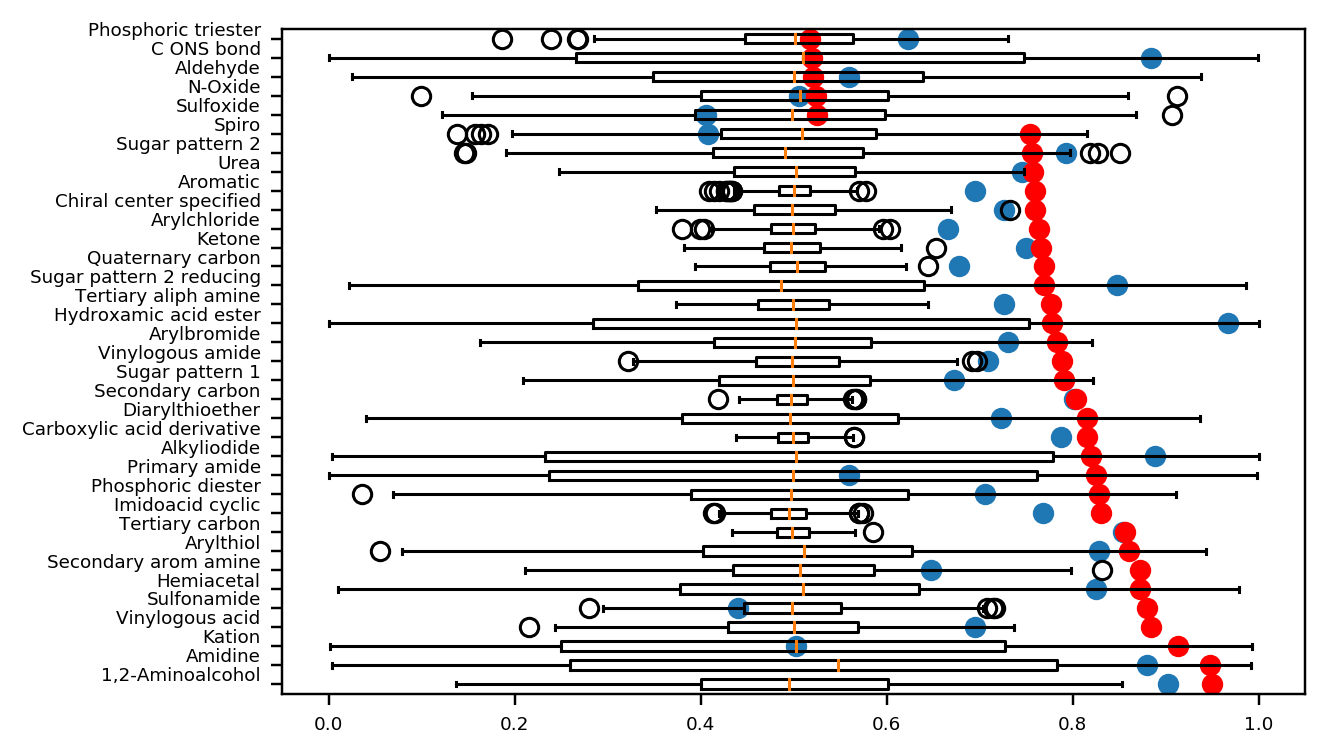

In [24]:
evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores)